In [39]:
from matplotlib import pyplot as plt
from data_utils import load_dataset
import numpy as np
import random
import math
import scipy 

# Q1: Laplace Approximation

In [5]:
def log_prior(w, variance):
    return ((-len(w)/2 * np.log(2 * np.pi)) - (len(w)/2 * np.log(variance)) - (1/(2 * variance) * np.dot(w.T, w)))


In [6]:
def prior_grad(w, variance):
    return -(w/(variance))

In [7]:
def prior_hess(w, variance):
    return np.multiply((-1/variance), np.identity(len(w)))

In [8]:
def ll_grad(X_train, estimate, true_y):

    grad = np.zeros(np.shape(X_train[0]))
    for i in range(len(estimate)):
        grad += (true_y[i] - sigmoid(estimate[i])) * X_train[i]
    return grad

In [9]:
def log_likelihood(estimate, y_train):
    likelihood = np.dot(y_train.T, np.log(sigmoid(estimate))) + np.dot(np.subtract(1, y_train).T, np.log(np.subtract(1, sigmoid(estimate))))
    return likelihood 

In [10]:
def ll_hess(X_train, estimate):
    hess = np.zeros((len(X_train[0]), len(X_train[0])))
    sig = np.multiply(sigmoid(estimate) , sigmoid(estimate) - 1)
    
    for i in range(len(estimate)):
        hess = np.outer(X_train[i], X_train[i].T)*np.add(hess, sig[i])
    return hess

In [11]:
def log_g(hess):
    return ((-len(hess)/2 * np.log(2*np.pi)) + (0.5 * np.log(np.linalg.det(-1*hess))) )

In [12]:
def get_acc(actual, pred):
    return (pred == actual).sum() / len(actual)

In [4]:
def sigmoid(z):
#     return 1/(1 + np.exp(-1*z))
    return np.divide(1, np.add(1, np.exp(-1*z)))

In [68]:
# Q1 : Laplace Approximation main block

def lap_approx(x_train, x_test, y_train, y_test, variances, rate):
    X_train = np.ones((x_train.shape[0], x_train.shape[1]+1))
    X_train[:, 1:] = x_train

    X_test = np.ones((x_test.shape[0], x_test.shape[1]+1))
    X_test[:, 1:] = x_test

    marg_likelihoods = dict()

    for variance in variances:
        w = np.zeros(np.shape(X_train[0]))
        num_it = 0

        x_prod = np.reshape(np.dot(X_train, w), np.shape(y_train))
        post_grad = ll_grad(X_train, x_prod, y_train) + prior_grad(w, variance)

        # Set a threshold for the posterior gradient -- once it is sufficiently small, break the loop 
        while max(post_grad) > 10**(-10):

            # compute estimates, gradients, and update
            x_prod = np.dot(X_train, w)
            post_grad = ll_grad(X_train, x_prod, y_train) + prior_grad(w, variance)
            w = np.add(w, rate*post_grad)

            num_it += 1

        # Calculate Hessian for the MAP solution 
        hessian = ll_hess(X_train, x_prod) + prior_hess(w, variance)

        # Calculate the marginal likelihood for this variance 
        marg_likelihoods[variance] = log_likelihood(x_prod, y_train) + log_prior(w, variance) - log_g(hessian)

        print('Iterations for variance = ' + str(variance) + ' is ' + str(num_it))
        print('MAP:', w)
        print('')

    return marg_likelihoods

In [69]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]

x_train, x_test = np.vstack((x_train, x_valid)), x_test
y_train, y_test = np.vstack((y_train, y_valid)), y_test

marginal_likelihood = lap_approx(x_train, x_test, y_train, y_test, [0.5,1,2],0.001)

print('')
for var in marginal_likelihood:
    print('For variance = ' + str(var) + ' , with a marginal likelihood of ' + str(marginal_likelihood[var]))
print('')

Iterations for variance = 0.5 is 9127
MAP: [-0.82007846  0.26552781 -1.14892351  0.44064204 -0.61761219]

Iterations for variance = 1 is 15400
MAP: [-0.87805271  0.29302957 -1.2347739   0.67815586 -0.89401743]

Iterations for variance = 2 is 23674
MAP: [-0.91617405  0.26897131 -1.2689827   0.99360561 -1.19178593]


For variance = 0.5 , with a marginal likelihood of [-71.90840702]
For variance = 1 , with a marginal likelihood of [-70.94230518]
For variance = 2 , with a marginal likelihood of [-70.54081376]



# Q2: Importance Sampling

In [73]:
def bernoulli_ll(x_vec, y_vec):
    b_ll = 1    
    for i in range(len(x_vec)):
        sig_x = sigmoid(x_vec[i])
        b_ll *= (sig_x **y_vec[i]) * ((1 - sig_x) ** (1 - y_vec[i]))
    return b_ll


In [74]:
def prior_ll(w, var):
    prior = 1
    for i in range(len(w)):
        prior *= (math.sqrt(2*math.pi*var) * math.exp(-(w[i]**2) / (2*var)))**(-1)
    return prior

In [75]:
def prop_ll(w, prop_var, mean):
    prop = 1
    for i in range(len(w)):
        prop *= (math.sqrt(2*math.pi*prop_var) * math.exp(-((mean[i] - w[i])**2) / (2*prop_var)))**(-1)
    return prop


In [76]:
def get_r(x_vec, y_vec, w_i, prior_var, prop_var, prop_mean):
    x_w = np.dot(x_vec, w_i)
    return ((bernoulli_ll(x_w, y_vec)*prior_ll(w_i, prior_var))/prop_ll(w_i, prop_var, prop_mean))

In [77]:
def prop(mean, var):
    return np.random.multivariate_normal(mean=mean, cov=np.eye(np.shape(mean)[0]) * var)
#     return np.random.multivariate_normal(mean=mean, cov=np.identity(np.shape(mean)[0]) * variance)

In [78]:
def Q2_get_predictions(x_training, x_testing, y_training, y_testing, w, sample_size, prior_var, prop_var, prop_mean):
    pred_cont = np.zeros(np.shape(y_testing))
    pred_disc = np.zeros(np.shape(y_testing))
                
    for k in range(len(x_testing)):
        sum_r = 0
        
        for j in range(sample_size):
            sum_r += get_r(x_training, y_training, w[j], prior_var, prop_var, prop_mean)
    
        pred_post = 0 
        for i in range(sample_size):
            pred_post += sigmoid(np.dot(x_testing[k], w[i]))*get_r(x_training, y_training, w[i], prior_var, prop_var, prop_mean)/sum_r
            
        pred_cont[k] = pred_post 
        
        # Discrete classification 
        if pred_post < 0.5:
            pred_disc[k] = 0 
        elif pred_post > 0.5:
            pred_disc[k] = 1
        else:
            pred_disc[k] = -1
    
    return [pred_cont, pred_disc]


In [98]:
def importance_sampling(train, test, visualize, x_training, x_testing, y_train, y_test, all_sample_sizes,prop_mean = [-0.91617405,  0.26897131, -1.2689827,   0.99360561, -1.19178593], prop_variances = [1, 2, 5, 10]):
    
    X_train = np.ones((x_training.shape[0], x_training.shape[1]+1))
    X_train[:, 1:] = x_training

    X_test = np.ones((x_testing.shape[0], x_testing.shape[1]+1))
    X_test[:, 1:] = x_testing
    
    prior_var = 1
    
    # Training 
    if train == True: 
        min_ll = float("inf")
        for ss in all_sample_sizes:
            # Train: list of proposal variances in prop_variances
            for prop_var in prop_variances:
                # Initialize weights 
                w = []
                for i in range(ss):
                    w.append(prop(prop_mean, prop_var))

                train_pred, train_pred_disc = Q2_get_predictions(X_train, X_test, y_train, y_test, w, ss, 1, prop_var, prop_mean)
                
                training_log_ll = -1*log_likelihood(train_pred, y_test)
                
                if training_log_ll < min_ll:
                    min_ll = training_log_ll
                    # Compute accuracy ratio (discrete)
                    best_acc = get_acc(y_test, train_pred_disc) 
                    best_var = prop_var
                    best_ss = ss
#                     print('BEST',min_ll,best_acc,best_var,best_ss)
        print("Best parameters: ", best_acc, best_var, best_ss)
        return [min_ll,best_acc,best_var,best_ss]

    elif test == True:
        prop_var = prop_variances[0]
        
        # all_sample_sizes contains [best_ss]
        for ss in all_sample_sizes:

            # Initialize weights 
            w = []
            for i in range(ss):
                # Test: best_var from training passed as prop_var 
                w.append(prop(prop_mean, prop_var))
            
            test_pred, test_pred_disc = Q2_get_predictions(X_train, X_test, y_train, y_test, w, ss, 1, prop_var, prop_mean)
            test_log_likelihood = -1*log_likelihood(test_pred, y_test)
            
            test_accuracy_ratio = get_acc(y_test, test_pred_disc)
            print("Test log-likelihood: " + str(test_log_likelihood))
            print("Test accuracy: " + str(test_accuracy_ratio))
            
    if visualize == True:
        prop_var = 2
        viz_ss = 5000
        w = []
        for i in range(viz_ss):
            w.append(prop(prop_mean,prop_var))
        sum_r = 0
        
        for j in range(viz_ss):
            sum_r += get_r(X_train, y_train, w[j], prior_var, prop_var, prop_mean)
    
        post = list() 
        for i in range(viz_ss):
            post.append(get_r(X_train, y_train, w[i], prior_var, prop_var, prop_mean)/sum_r)
      
        for i in range(5):
            wgts = list()
            # Get weight components
            for j in range(len(w)):
                wgts.append(w[j][i])

            wgts, post = zip(*sorted(zip(wgts, post)))
            w_all = np.arange(min(wgts), max(wgts), 0.001)
            
            # Gaussian 

            z = np.squeeze(np.polyfit(wgts, post, 1))
            p = np.poly1d(z)
    
            q_w = scipy.stats.norm.pdf(w_all, prop_mean[i], prop_var)
            plt.figure(i)

            plt.plot(w_all, q_w, '-b', label="Proposal distr. [q(w)]")
            plt.plot(wgts, post, 'xr', label="Posterior distr. [P(w|X,y)]")
            plt.plot(wgts, p(wgts),"r--")

            plt.title("Posterior visualization: q(w) mean=" + str(round(prop_mean[i], 2)) + " var=" + str(prop_var))
            plt.xlabel("w[" + str(i) + "]")
            plt.ylabel("Probability")            
            plt.legend()
            plt.savefig("Visualization for w[" + str(i) + "].png")        
        
    return

In [92]:
# Training 

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]

all_sample_sizes = [5, 10, 20, 50, 100]
min_ll,best_acc,best_var,best_ss = importance_sampling(True, False, False, x_train, x_valid, y_train,y_valid, all_sample_sizes)

BEST [[22.98125311]] 0.7096774193548387 1 5
BEST [[22.94477587]] 0.6774193548387096 2 5
BEST [[21.33166504]] 0.7096774193548387 5 5
BEST [[21.08158596]] 0.7096774193548387 10 50
Best parameters:  0.7096774193548387 10 50


Test log-likelihood: [[22.91717792]]
Test accuracy: 0.6774193548387096


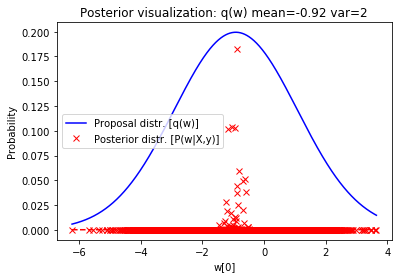

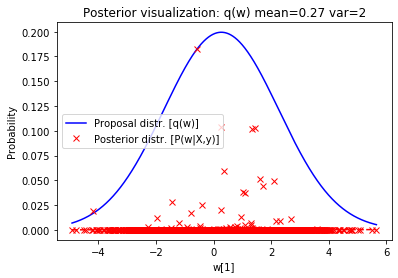

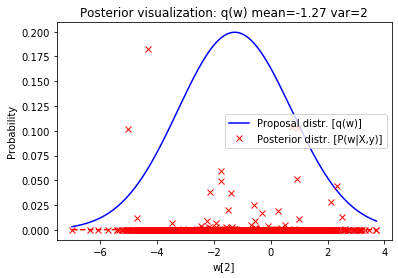

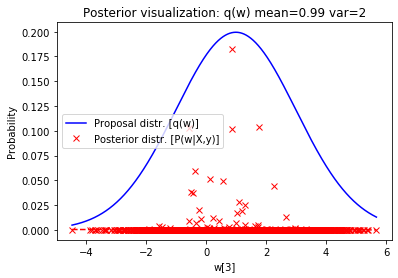

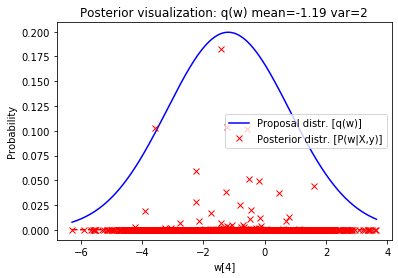

In [100]:
# Testing and Visualization 
x_train, x_test = np.vstack((x_train, x_valid)), x_test
y_train, y_test = np.vstack((y_train, y_valid)), y_test

importance_sampling(False, True, True, x_train, x_valid, y_train,y_valid, all_sample_sizes=[best_ss], prop_variances = [best_var])